In [1]:
import autoencoder.adversarial as aae
import autoencoder.utils as utils 
import autoencoder.cluster_layer as clay

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
esize = [(64,3), (128, 3), (256,3)]
dsize = list(reversed(esize))

params =dict()

params['nclusters'] = 20
params['width'] = 32
params['height'] = 32
params['nchannels'] = 4
params['channels'] = [0,1,3,4]
params['nepochs'] = 20
params['batchsize'] = 256
params['learning_rate'] = 0.0005
params['restore'] = False
params['latent_size'] = 256
params['enc_sizes'] = esize 
params['dec_sizes'] = dsize
params['droprate'] = 0.85
params['stdev'] = 0.04
params['denoise'] = False
params['slam'] = 0

datadir = "/media/cjw/Data/cyto/mmCompensatedTifs/"
cpf = "/media/cjw/Data/cyto/Checkpoints/2018-09-05-10-58-21_idec_try_3/"
cpf += "checkpoint-2018-09-05-10-58-21/autoencoder-256x-20000"
cpd = ""

In [3]:
rl = aae.aae_loader(params, datadir, cpf, cpd)

In [4]:
rl.load()


Encoder True
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
isize:  4 32
dh0 (?, 32, 32, 4)
[<tf.Variable 'encoder/filter_00/kernel:0' shape=(3, 3, 4, 64) dtype=float32_ref>, <tf.Variable 'encoder/filter_00/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'encoder/filter_01/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'encoder/filter_01/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'encoder/filter_02/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'encoder/filter_02/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'encoder/latent_space/kernel:0' shape=(4096, 256) dtype=float32_ref>, <tf.Variable 'encoder/latent_space/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/dense/kernel:0' shape=(256, 4096) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(4096,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable

In [5]:
cluster = clay.cluster_train(rl)

(4000, 32, 32, 4)
building cluster layer (?, 256)
after input_spec
20 256 <class 'int'> float32
(20, 256)
(20, 256)
done building
0 1415.7946 1.3768127
100 1412.8295 1.7052356
200 1412.1886 2.3258111
300 1411.2231 2.0541077
400 1410.9896 2.263179
500 1410.5039 2.2168188
600 1410.2458 2.217803
700 1410.0549 2.140171
800 1410.0614 2.1662374
900 1409.8353 2.226112
1000 1409.786 2.198842
1100 1409.6594 2.1104105
1200 1409.6052 2.1038177
1300 1409.4843 1.9840837
1400 1409.526 2.0398664
1500 1409.5529 2.046447
1600 1409.388 1.9915384
1700 1409.3176 1.9665546
1800 1409.3898 2.0278938
1900 1409.2821 1.898514
2000 1409.2397 1.8769851
2100 1409.2825 1.9457538
2200 1409.0968 1.8802918
2300 1409.1553 1.8733156
2400 1409.1836 1.8743949
2500 1409.0728 1.7996422
2600 1409.1361 1.8135763
2700 1408.9608 1.7531171
2800 1408.9818 1.6921957
2900 1408.9326 1.7310069
3000 1408.887 1.6895746
3100 1408.928 1.6991307
3200 1408.9019 1.6659092
3300 1408.8901 1.6691699
3400 1408.8489 1.668073
3500 1408.8298 1.660

In [6]:
b = utils.get_sample(rl.mmdict, rl.df, 64, 32, 4, [0,1,3,4])

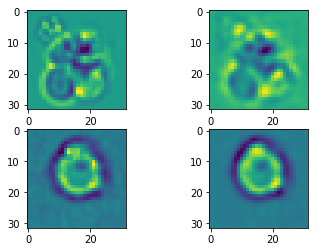

In [7]:
z = rl.encoder.eval({rl.images:b}, session=rl.sess)
dc = rl.decoder.eval({rl.encoder:z}, session=rl.sess)

index = 16
c = 0
dr = np.squeeze(dc[index,:,:,c])
plt.subplot(2,2,1)
plt.imshow(b[index,:,:,c])
plt.subplot(2,2,2)
plt.imshow(dr)

dr = np.squeeze(dc[index + 1,:,:,c])
plt.subplot(2,2,3)
plt.imshow(b[index + 1,:,:,c])
plt.subplot(2,2,4)
plt.imshow(dr)

In [8]:
q = cluster.call(rl.encoder)
qv = q.eval({rl.encoder:z}, session=rl.sess)
p = clay.cluster_target(qv)
np.sum(p, axis=0)

array([2.967824 , 3.2823722, 2.8142111, 3.2619913, 3.0659008, 3.3312962,
       3.3513598, 3.042171 , 3.268912 , 3.2614596, 3.2625282, 2.9046826,
       3.292423 , 3.3397822, 3.270161 , 3.4035847, 3.2622504, 3.359957 ,
       3.3703692, 2.8867612], dtype=float32)

In [11]:
tf.norm(q, axis=1).eval({rl.encoder:z[3:12,:]}, session=rl.sess), q

(array([0.0316568 , 0.02044343, 0.02339109, 0.02514954, 0.02638595,
        0.01727927, 0.03709933, 0.02605809, 0.01771378], dtype=float32),
 <tf.Tensor 'truediv_1:0' shape=(?, 20) dtype=float32>)

In [12]:
np.linalg.norm(np.array([1,2,-3]), ord=2, axis=0)
#qv

3.7416573867739413

In [16]:
from scipy.spatial.distance import euclidean
wgh = rl.sess.run(cluster.weights)
wgh = wgh[0]

for p in z:
    print(np.linalg.norm(wgh[16] - p, ord=2))


19.001009
11.914553
16.337908
14.090536
16.87099
16.261274
15.716951
15.21926
19.328566
12.628974
15.6603155
18.667034
16.189457
18.20206
12.420375
15.186619
19.009365
15.099071
16.971
16.294735
15.866109
16.918253
16.053848
18.387241
14.63199
15.5549345
13.599409
18.308218
16.581219
16.001543
15.476675
14.521224
15.873012
19.787348
14.028216
16.361898
17.116663
14.079108
14.015634
14.0414095
14.652005
15.092773
14.25707
16.335745
17.185486
16.724457
13.777287
14.480114
16.445581
15.483241
14.339938
16.076242
10.990418
16.229929
14.79871
16.435984
16.995317
15.013858
16.888195
16.243765
15.186875
14.470603
15.377631
14.630332


(1, 256)

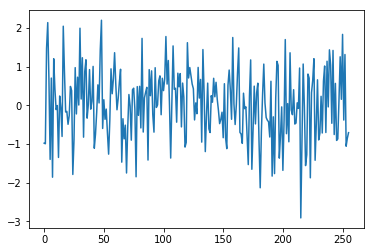

In [304]:
from scipy.signal import convolve

zi = np.copy(z[index:index+2])
#zi = np.expand_dims(zi, 0)
zi = -zi[0]# + zi[1]
#zi = convolve(zi, np.array([1])/1, mode='same')
#zi[np.abs(zi) < .5] *= 0
rx = np.random.randint(0, 256, 10)
#zi[rx] = 10
#zi = np.sum(zi, axis=0)/2
zi = np.expand_dims(zi, 0)
plt.plot(zi[0])
zi.shape

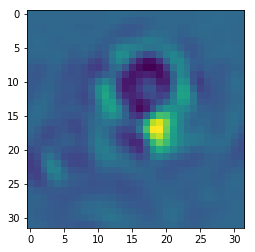

In [305]:
di = rl.decoder.eval({rl.encoder:zi}, session=rl.sess)
plt.imshow(np.squeeze(di[0,:,:,0]))